<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/56_10kGNAD_fastai2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training FastAI Classifier

based on https://github.com/floleuerer/fastai_ulmfit/blob/main/4_ulmfit_train_classifier.ipynb

## Prerequisites

### Connect Google Drive

In [6]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/gdrive')

# model location
root_path = Path('/content/gdrive/My Drive/')
base_path = root_path / 'Colab Notebooks/nlp-classification/'
model_path = base_path / 'models'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec  5 20:56:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   6709MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Libraries

In [7]:
!pip install -q -U fastai sentencepiece!=0.1.90,!=0.1.91

!pip freeze | grep fastai
!pip freeze | grep sentencepiece
!pip freeze | grep torch
# fastai==2.5.3
# sentencepiece==0.1.96
# torch==0.10.0+cu111

fastai==2.5.3
sentencepiece==0.1.96
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl


### Fetch Model Data

In [12]:
!cp -r "$model_path/10kgnad_fastai2/" model
!ls -lah model

total 202M
drwx------ 3 root root 4.0K Dec  5 19:42 .
drwxr-xr-x 1 root root 4.0K Dec  5 19:42 ..
drwx------ 2 root root 4.0K Dec  5 19:42 10kgnad_fastai2
-rw------- 1 root root 502K Dec  5 19:42 de_15k_spm.model
-rw------- 1 root root 283K Dec  5 19:42 de_15k_spm.vocab
-rw------- 1 root root 101M Dec  5 19:42 de_lm_finetune_encoder.pth
-rw------- 1 root root 101M Dec  5 19:42 de_lm_finetune_model.pth
-rw------- 1 root root 284K Dec  5 19:42 de_lm_finetune_vocab.pkl


### Fetch Data

In [13]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data
2021-12-05 19:43:32 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-12-05 19:43:33 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]

2.7M Dec  5 19:43 test.csv
 24M Dec  5 19:43 train.csv


### Import Data

In [16]:
import pandas as pd

data_dir = Path("data/")

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

def read_csv_10kGNAD(filepath: Path, columns=["labels", "text"]) -> pd.DataFrame:
    """Load 10kGNAD csv file, handling its specific file format."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [17]:
train_df = read_csv_10kGNAD(data_dir / 'train.csv')
print(train_df.shape[0], 'articles')
display(train_df.head())

9245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [18]:
test_df = read_csv_10kGNAD(data_dir / 'test.csv')
print(test_df.shape[0], 'articles')
display(test_df.head())

1028 articles


,labels,text
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


## Create Model

In [19]:
from fastai.text.all import *

lang= "de"

tok = SentencePieceTokenizer(lang=lang, sp_model="model/de_15k_spm.model")

In [44]:
lm_ft_fns = [(f'{os.getcwd()}/model/de_lm_finetune_model'), 
             (f'{os.getcwd()}/model/de_lm_finetune_vocab.pkl'),
             (f'{os.getcwd()}/model/de_lm_finetune_encoder')]

with open(f'{lm_ft_fns[1]}', 'rb') as f:
      vocab = pickle.load(f)

In [26]:
bs=64
num_workers=18

dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab, backwards=False), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('labels'), 
                    # splitter=ColSplitter()
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(train_df, bs=bs, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
dls.vocab[1]

['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web', 'Wirtschaft', 'Wissenschaft']

In [29]:
len(dls.train), len(dls.valid)

(130, 15)

In [28]:
dls.show_batch()

,text,category
0,"▁xxbos ▁xxmaj ▁neues ▁xxmaj ▁windows ▁wird ▁seit ▁xxmaj ▁mittwoch ▁als ▁xxmaj ▁download ▁an ▁private ▁xxmaj ▁nutzer ▁verteilt . ▁xxmaj ▁da ▁ist ▁es ▁nun ▁also . ▁xxmaj ▁das ▁erste ▁xxmaj ▁windows ▁unter ▁der ▁ ä gi de ▁des ▁neuen ▁microsoft - chefs ▁xxmaj ▁ sat ya ▁xxmaj ▁nadella . ▁xxmaj ▁und ▁sein ▁xxmaj ▁baby ▁namens ▁xxmaj ▁windows ▁10 ▁soll ▁nicht ▁nur ▁jene ▁xxmaj ▁nutzer ▁zurück gewinn en , ▁die ▁mit ▁dem ▁zu ▁radikal ▁auf ▁xxmaj ▁touch ▁first ▁ausgerichtet en ▁xxmaj ▁windows ▁8 ▁nichts ▁anfang en ▁konnten , ▁sondern ▁auch ▁die ▁ ära ▁von ▁xxmaj ▁windows ▁10 ▁als ▁xxmaj ▁dienst leistung ▁ein leit en . ▁xxmaj ▁seit ▁heute ▁verteilt ▁xxmaj ▁microsoft ▁sein ▁neues ▁xxmaj ▁betriebssystem ▁xxmaj ▁windows ▁10 ▁an ▁private ▁xxmaj ▁ anwender ▁– ▁als ▁xxmaj ▁download . ▁xxmaj ▁das ▁xxmaj ▁ upgrade ▁gibt ▁es ▁kostenlos ▁für ▁alle , ▁die ▁derzeit ▁mit ▁xxmaj ▁windows ▁ 7 ▁oder ▁8 ▁arbeiten . ▁xxmaj ▁später",Web
1,"▁xxbos ▁"" w o ▁sind ▁xxmaj ▁sie ▁daheim ? "" ▁xxmaj ▁diese ▁xxmaj ▁frage ▁war ▁schwer ▁zu ▁beantworten . ▁xxmaj ▁david ▁st ach ▁mit ▁dem ▁xxmaj ▁zeige finger ▁auf ▁seine ▁xxmaj ▁brust ▁und ▁sagte : ▁"" i ▁am ▁from ▁xxmaj ▁ sy ria , ▁ i ▁am ▁ a ▁masse ur , ▁now ▁in ▁la a - an - der - th aya "" ▁– ▁das ▁ging ▁ihm ▁schon ▁ganz ▁gut ▁von ▁den ▁xxmaj ▁ li pp en . ▁xxmaj ▁am ▁27. ▁xxmaj ▁august ▁2015 ▁stieg ▁der ▁xxmaj ▁mann ▁in ▁den ▁weißen ▁xxmaj ▁bus ▁mit ▁drei ▁grünen ▁xxmaj ▁ tan n en ▁an ▁der ▁xxmaj ▁seite , ▁ bezahlte ▁beim ▁xxmaj ▁fahrer ▁15 ▁xxmaj ▁euro : ▁la a - an - der - th aya , ▁ ple as e , ▁ging ▁die ▁xxmaj ▁ reihen ▁entlang ▁und ▁wählte ▁einen ▁der ▁hinter en ▁xxmaj ▁plätze . ▁xxmaj ▁den ▁kleinen ▁xxmaj",Panorama
2,"▁xxbos ▁xxmaj ▁kurz ▁vor ▁xxmaj ▁beginn ▁der ▁xxup ▁wm ▁ pla ud ert ▁österreichs ▁neuseeländische r ▁xxmaj ▁ teamchef ▁aus ▁dem ▁xxmaj ▁ n ä h k ä st chen : ▁"" geht ▁nicht "" ▁gibt ▁es ▁für ▁den ▁ leidenschaft lichen ▁xxmaj ▁sport s mann ▁nicht . ▁xxmaj ▁philip ▁xxmaj ▁ lo ft y ▁xxmaj ▁steve n son ▁ist ▁der ▁erste ▁profi - trainer ▁in ▁der ▁noch ▁nicht ▁gar ▁so ▁langen ▁ r ug by - hi s to rie ▁österreichs . ▁xxmaj ▁seit ▁zwei ▁xxmaj ▁jahren ▁ coach t ▁er ▁die ▁österreichische ▁xxmaj ▁national mannschaft , ▁doch ▁ist ▁der ▁50 - jährige ▁viel ▁mehr ▁als ▁bloß ▁xxmaj ▁ teamchef . ▁xxmaj ▁seine ▁xxmaj ▁ mission : ▁den ▁xxmaj ▁sport ▁in ▁allen ▁xxmaj ▁ face tten ▁auf ▁ein ▁höhere s ▁xxmaj ▁entwicklungs niveau ▁zu ▁ hi e ven ▁– ▁ organisator isch , ▁spieler isch , ▁überhaupt . ▁xxmaj",Sport
3,"▁xxbos ▁xxmaj ▁stich t ▁mit ▁xxmaj ▁mut ▁zu ▁ungewöhnlich em ▁xxmaj ▁design ▁und ▁frisch en ▁xxmaj ▁software konzept en ▁aus ▁der ▁xxmaj ▁masse ▁heraus . ▁xxmaj ▁es ▁passiert ▁nur ▁selten , ▁dass ▁ein ▁neues ▁xxmaj ▁smartphone ▁in ▁der ▁xxmaj ▁ redaktion ▁ein tri ff t , ▁das ▁wirklich ▁aus ▁der ▁xxmaj ▁masse ▁heraus s ti cht . ▁xxmaj ▁scheint ▁es ▁doch ▁fast ▁so , ▁als ▁hätten ▁sich ▁die ▁großen ▁xxmaj ▁hersteller ▁mittlerweile ▁allesamt ▁auf ▁eine ▁gemeinsame ▁design - linie ▁geeinigt . ▁xxmaj ▁um ▁so ▁er fr ischen der ▁ist ▁es , ▁wenn ▁dann ▁einmal ▁ein ▁xxmaj ▁smartphone ▁auf taucht , ▁das ▁aus ▁dieser ▁xxmaj ▁ uniform ität ▁aus bricht ▁– ▁vor ▁allem , ▁wenn ▁es ▁von ▁einem ▁xxmaj ▁new com er ▁kommt , ▁der ▁noch ▁dazu ▁mit ▁frisch en ▁xxmaj ▁software ide en ▁auf wart en ▁kann . ▁xxmaj ▁robin ▁heißt ▁das ▁erste ▁xxmaj ▁smartphone ▁von ▁xxmaj ▁ n ex",Web
4,"▁xxbos ▁xxmaj ▁dichter in ▁xxmaj ▁ fried er ik e ▁xxmaj ▁ mayr öck er ▁über ▁das ▁xxmaj ▁nicht suche n ▁und ▁xxmaj ▁nicht finden , ▁ihren ▁xxmaj ▁heiligen ▁xxmaj ▁ geist ▁der ▁xxmaj ▁er le uch t ung ▁und ▁den ▁xxmaj ▁tod ▁als ▁xxmaj ▁ skandal . ▁xxup ▁standard : ▁xxmaj ▁ich ▁habe ▁xxmaj ▁ihnen ▁eine ▁weiße ▁xxmaj ▁ li lie ▁mit gebracht . ▁xxmaj ▁sie ▁lieben ▁die ▁xxmaj ▁natur , ▁xxmaj ▁blumen , ▁besonders ▁xxmaj ▁ li li en . ▁xxmaj ▁ mayr öck er : ▁xxmaj ▁je ▁älter ▁ich ▁werde , ▁ desto ▁mehr ▁liebe ▁ich ▁die ▁xxmaj ▁natur . ▁xxup ▁standard : ▁xxmaj ▁so ▁ge pr ä gt ▁sind ▁xxmaj ▁sie ▁von ▁xxmaj ▁ihren ▁xxmaj ▁ aufenthalt en ▁als ▁xxmaj ▁kind 

## Train Model

In [30]:
avg = 'macro'
metrics=[accuracy, Precision(average=avg), Recall(average=avg), F1Score(average=avg)]

In [46]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()
# learn.path = model_path

In [48]:
# we only need the encoder
learn.load_encoder(lm_ft_fns[2])

SuggestedLRs(valley=0.002511886414140463)

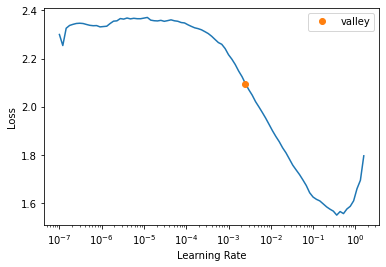

In [49]:
learn.lr_find()

In [52]:
lr = 2e-3
lr *= bs/48
lr

0.0026666666666666666

In [53]:
learn.fine_tune(5, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.993807,0.534702,0.817100,0.822046,0.792903,0.799285,00:56


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.736728,0.482000,0.830087,0.838897,0.815440,0.821216,02:13
1,0.683906,0.463725,0.849567,0.860249,0.831223,0.842701,02:14
2,0.638055,0.442621,0.843074,0.856319,0.828064,0.837794,02:15
3,0.629830,0.416792,0.850649,0.858313,0.837460,0.844798,02:15
4,0.560555,0.415546,0.856061,0.861613,0.842436,0.848896,02:16


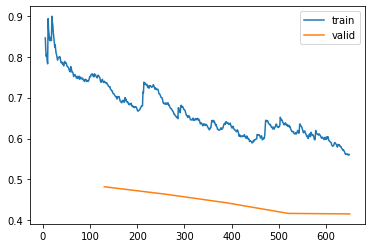

In [54]:
learn.recorder.plot_loss()

In [56]:
model_path/f'de_lm_finetune_encoder'

Path('/content/gdrive/My Drive/Colab Notebooks/nlp-classification/models/de_lm_finetune_encoder')

In [58]:
learn.to_fp32()

In [59]:
learn.export(model_path/f'de_cls_finetune.pkl')

## Prediction

In [60]:
learn.predict("Beim Spiel gegen Arminia Bielefeld konnte Müller wieder zum Zug kommen")

('Sport',
 TensorText(5),
 TensorText([7.4133e-03, 1.7623e-02, 4.2638e-04, 1.9827e-02, 2.4012e-04, 9.4605e-01,
         7.0021e-03, 8.4814e-04, 5.7048e-04]))

In [96]:
test_dl = learn.dls.test_dl(test_df) # Create a test dataloader
preds = learn.get_preds(dl = test_dl) # Make predictions on it

In [97]:
preds_df = pd.DataFrame([tensor.numpy() for tensor in preds[0]], columns=dls.vocab[1])

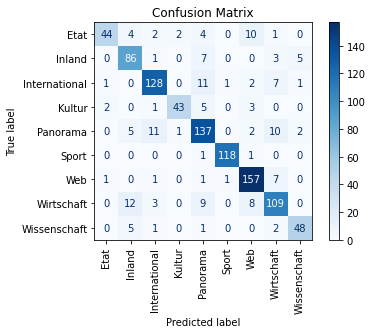

In [99]:
import sklearn.metrics as skm

test_labels = test_df.labels
pred_labels = preds_df.idxmax(axis=1)
labels = dls.vocab[1]

cm = skm.confusion_matrix(test_labels, pred_labels, labels=labels)
cmd = skm.ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix");

In [91]:
print(skm.classification_report(test_labels, pred_labels))

               precision    recall  f1-score   support

         Etat       0.92      0.66      0.77        67
       Inland       0.77      0.84      0.80       102
International       0.86      0.85      0.86       151
       Kultur       0.93      0.80      0.86        54
     Panorama       0.78      0.82      0.80       168
        Sport       0.98      0.98      0.98       120
          Web       0.86      0.93      0.89       168
   Wirtschaft       0.78      0.77      0.78       141
 Wissenschaft       0.86      0.84      0.85        57

     accuracy                           0.85      1028
    macro avg       0.86      0.83      0.84      1028
 weighted avg       0.85      0.85      0.85      1028



In [100]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, hamming_loss, matthews_corrcoef

print(f"{accuracy_score(test_labels, pred_labels):.4} accuracy")
print(f"{precision_score(test_labels, pred_labels, average='macro'):.4} precision (macro)")
print(f"{recall_score(test_labels, pred_labels, average='macro'):.4} recall (macro)")
print(f"{f1_score(test_labels, pred_labels, average='macro'):.4} f1 (marco)")
print(f"{f1_score(test_labels, pred_labels, average='weighted'):.4} f1 (weighted)")
print(f"{matthews_corrcoef(test_labels, pred_labels):.4} mcc")
print(f"{hamming_loss(test_labels, pred_labels):.4} hamming loss")

0.8463 accuracy
0.8606 precision (macro)
0.8325 recall (macro)
0.8431 f1 (marco)
0.8456 f1 (weighted)
0.8238 mcc
0.1537 hamming loss
